In [290]:
from nomic import embed 
import nomic 
from dotenv import load_dotenv
import os
import base64
import numpy as np 
import json
import matplotlib.pyplot as plt 
from pinecone import Pinecone, ServerlessSpec

load_dotenv()

nomic.login(os.getenv("NOMIC_API_KEY"))
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [58]:
def cleanData(item):
    """
    Clean individual item data, keeping only English entries and specified fields.
    Returns None if no English item name exists.
    """
    # First check if there's an English item name - if not, skip this item
    hasEnglishName = False
    englishName = None
    
    for name in item.get('item_name', []):
        if name.get('language_tag', '').startswith('en'):
            hasEnglishName = True
            englishName = name['value']
            break
    
    if not hasEnglishName:
        return None
        
    # Initialize cleaned data with the basic fields
    cleanedItem = {
        'title': englishName,
        'otherImageIds': item.get('other_image_id', []),
        'mainImageId': item.get('main_image_id'),
        'country': item.get('country'),
        'domainName': item.get('domain_name'),
        'bulletPoints': [],
        'keywords': [],
        'color': None,
        'productType': None,
        'style': None
    }
    
    # Extract English bullet points
    for point in item.get('bullet_point', []):
        if point.get('language_tag', '').startswith('en'):
            cleanedItem['bulletPoints'].append(point['value'])
    
    # Extract English keywords
    for keyword in item.get('item_keywords', []):
        if keyword.get('language_tag', '').startswith('en'):
            cleanedItem['keywords'].append(keyword['value'])
    
    # Extract English color
    for color in item.get('color', []):
        if color.get('language_tag', '').startswith('en'):
            cleanedItem['color'] = color['value']
            break
    
    # Extract product type (usually doesn't have language tag)
    if item.get('product_type'):
        cleanedItem['productType'] = item['product_type'][0].get('value')
    
    # Extract English style
    for style in item.get('style', []):
        if style.get('language_tag', '').startswith('en'):
            cleanedItem['style'] = style['value']
            break
    
    return cleanedItem

def processJsonFile(filePath):
    """
    Process the entire JSON file and return cleaned data
    """
    cleanedData = []
    
    with open(filePath, 'r') as file:
        for line in file:
            item = json.loads(line)
            cleanedItem = cleanData(item)
            if cleanedItem:  # Only append if item has English title
                cleanedData.append(cleanedItem)
    
    return cleanedData

# Example usage
files = [f"metadata/listings_{hex(i)[2:]}.json" for i in range(16)]

allCleanedData = []
for file in files: 
    cleanedData = processJsonFile(file)
    allCleanedData.extend(cleanedData)

print(len(allCleanedData))


    


122734


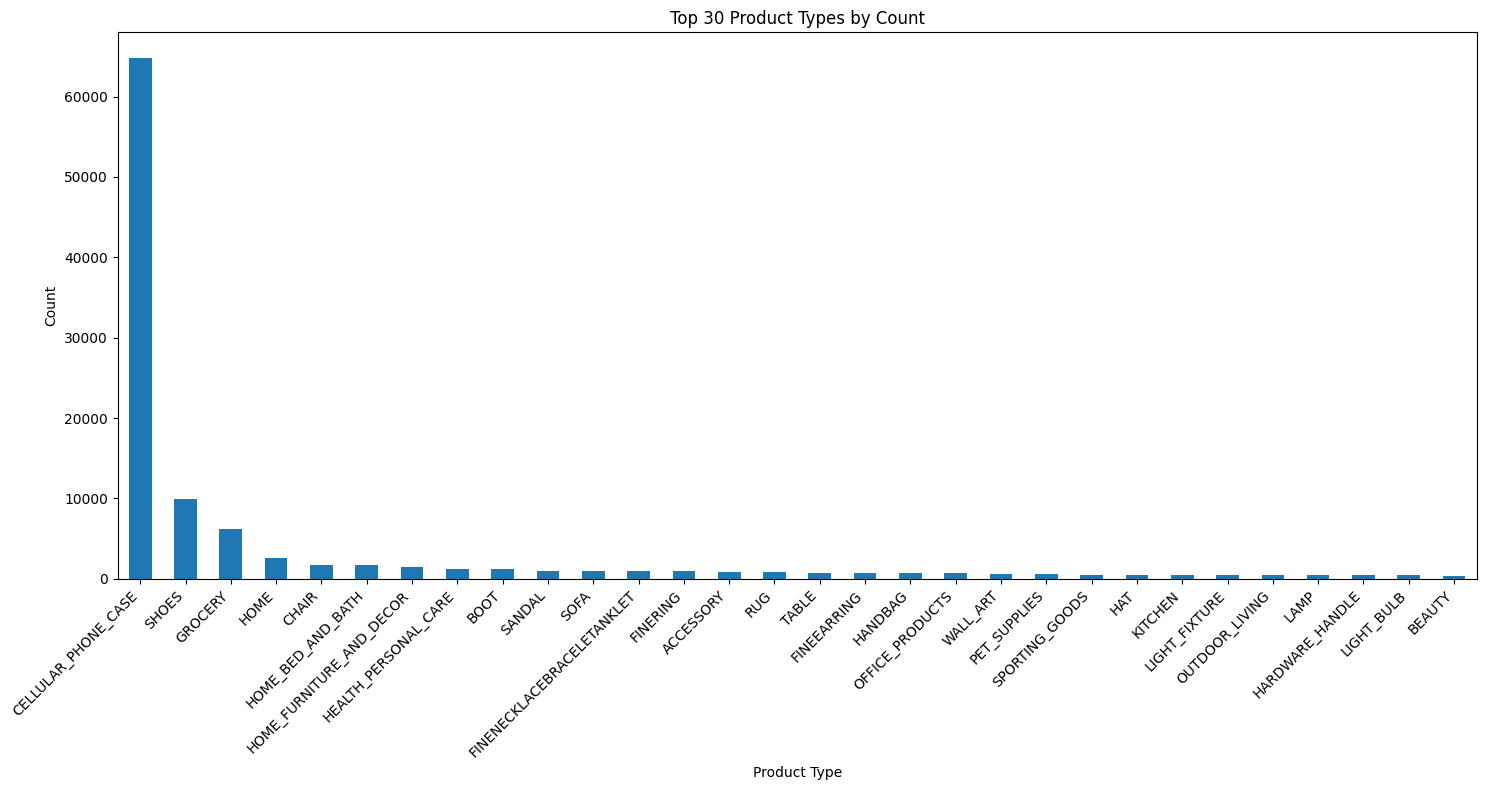

In [60]:
# Create a bar chart showing product type distribution
productTypeCounts = df['productType'].value_counts().head(30)  # Get top 30 categories
plt.figure(figsize=(15, 8))
productTypeCounts.plot(kind='bar')
plt.title('Top 30 Product Types by Count')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
SHOE_PRODUCT_TYPES = ["SHOES", "SANDAL", "BOOT", "TECHNICAL_SPORT_SHOE"]
images = "metadata/images.csv"

imageDf = pd.read_csv(images)

# Join the dataframes on mainImageId and image_id
mergedDf = df.merge(imageDf, left_on='mainImageId', right_on='image_id', how='left')
mergedDf.head()

# Filter for shoe products and large images
shoeImages = mergedDf[
    (mergedDf['productType'].isin(SHOE_PRODUCT_TYPES)) & 
    (mergedDf['height'] > 500) & 
    (mergedDf['width'] > 500)
]

print(f"Found {len(shoeImages)} shoe images larger than 500x500 pixels")

/var/folders/9g/5n15ph9x3cg2325kls7cr5_w0000gn/T/ipykernel_14142/1358794965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shoeImages.loc[:, 'fullImagePath'] = shoeImages['path'].apply(lambda x: IMAGE_MAIN_DIRECTORY + x)


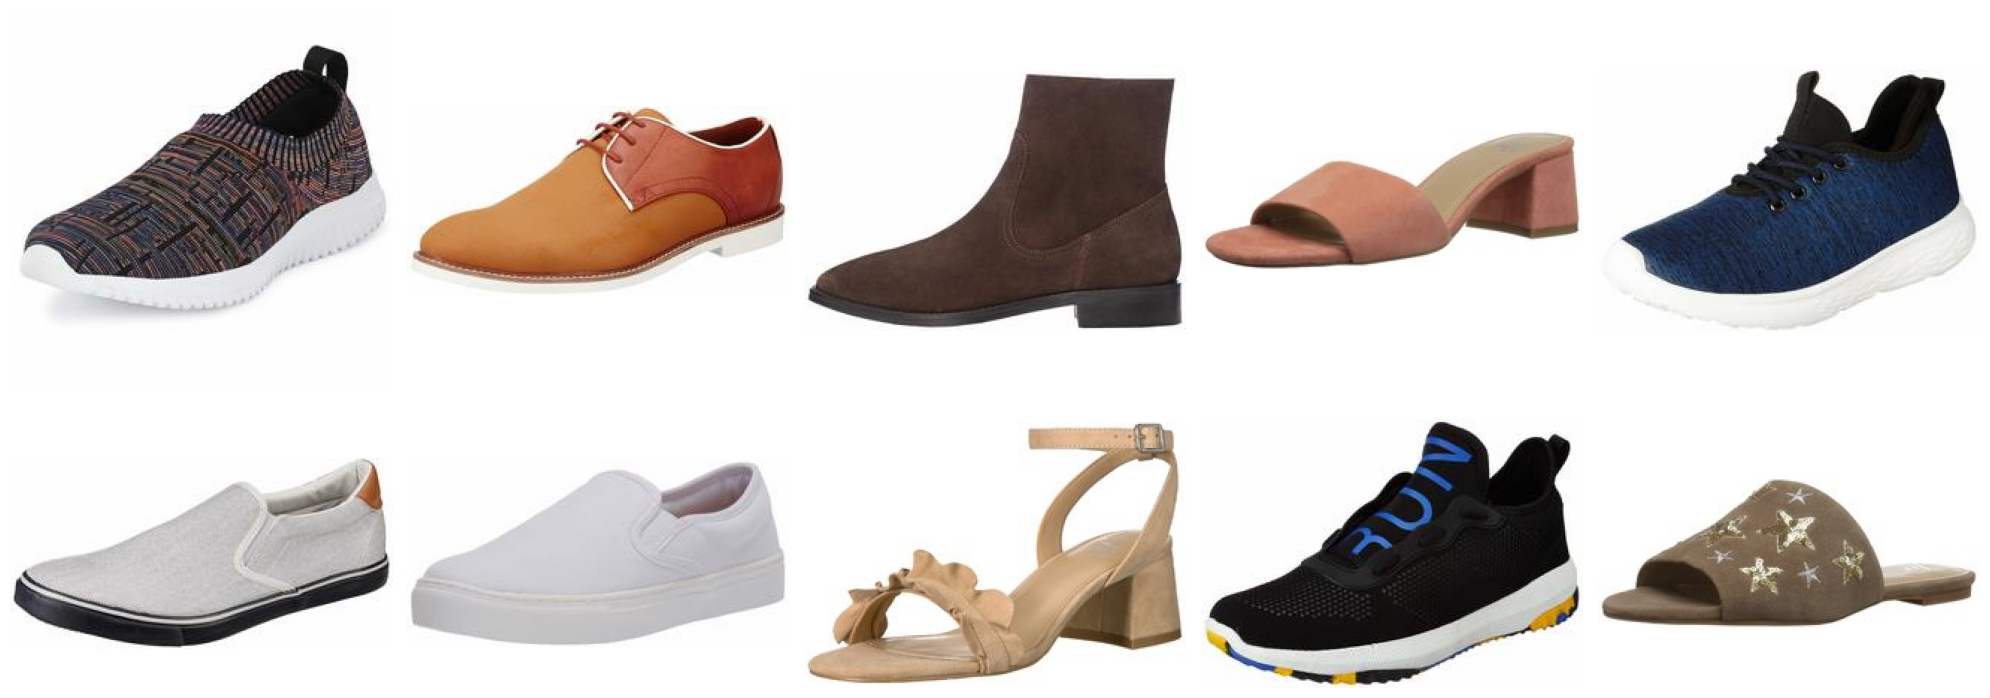

In [64]:
IMAGE_MAIN_DIRECTORY = "small/"

# Get full image paths by joining directory and path
shoeImages.loc[:, 'fullImagePath'] = shoeImages['path'].apply(lambda x: IMAGE_MAIN_DIRECTORY + x)

# Get 10 random shoe images
randomShoeImages = shoeImages.sample(n=10, random_state=42)

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# Plot each image
for idx, (_, row) in enumerate(randomShoeImages.iterrows()):
    img = plt.imread(row['fullImagePath'])
    axes[idx].imshow(img)
    axes[idx].axis('off')
    # axes[idx].set_title(f"Product: {row['productType']}\nStyle: {row['style']}")

plt.tight_layout()
plt.show()

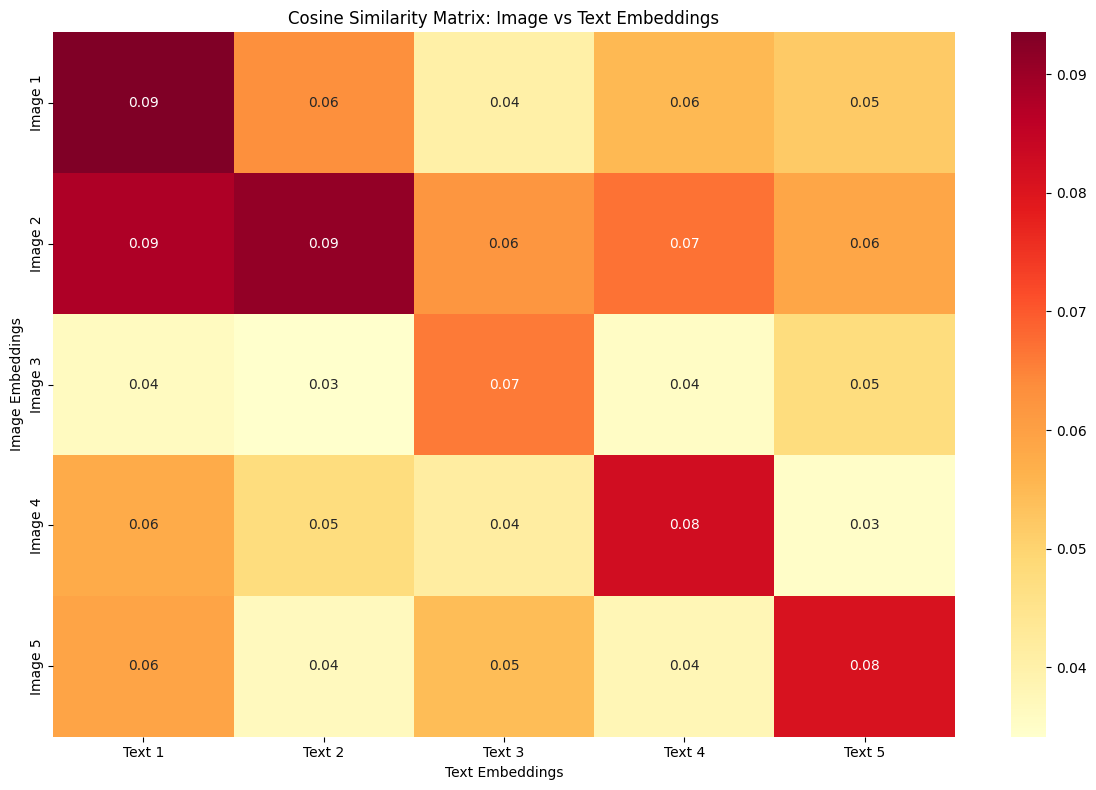


Diagonal values (matching pairs):
Pair 1 similarity: 0.0935
Pair 2 similarity: 0.0911
Pair 3 similarity: 0.0660
Pair 4 similarity: 0.0822
Pair 5 similarity: 0.0809


In [288]:
# Plots the cross cosine similarity of all the images and their descriptions created by the following
def createDescription(row): 
    return f"Title: {row['title']}. \nColor: {row['color']}.\nStyle: {row['style']}. \nProductType: {row['productType']}. \nBullet Points: {";".join(row['bulletPoints'])}"

randomShoeImages.loc[:, 'createdDescription'] = randomShoeImages.apply(createDescription, axis=1)
randomSubset = randomShoeImages.sample(n=5)


# Create list of image paths
imagePaths = randomSubset['fullImagePath'].tolist()
imageDescriptions = randomSubset['createdDescription'].tolist()

# Embed images using nomic vision
imageEmbeddingsResult = embed.image(
    images=imagePaths,
    model='nomic-embed-vision-v1.5',
)

textEmbeddingResult = embed.text(texts=imageDescriptions, model="nomic-embed-text-v1.5", task_type="search_document")

imageEmbeddings = np.array(imageEmbeddingsResult['embeddings'])
textEmbeddings = np.array(textEmbeddingResult['embeddings'])

# Calculate cosine similarity between corresponding image and text embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Reshape embeddings to 2D arrays for cosine_similarity
imageEmbeddings2D = imageEmbeddings.reshape(len(imagePaths), -1)
textEmbeddings2D = textEmbeddings.reshape(len(imageDescriptions), -1)

# Calculate cosine similarity matrix between all image and text embeddings
similarityMatrix = cosine_similarity(imageEmbeddings2D, textEmbeddings2D)

# Plot similarity matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(similarityMatrix, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=[f'Text {i+1}' for i in range(5)],
            yticklabels=[f'Image {i+1}' for i in range(5)])
plt.title('Cosine Similarity Matrix: Image vs Text Embeddings')
plt.xlabel('Text Embeddings')
plt.ylabel('Image Embeddings')
plt.tight_layout()
plt.show()

# Print diagonal values (matching pairs)
print("\nDiagonal values (matching pairs):")
for i in range(5):
    print(f"Pair {i+1} similarity: {similarityMatrix[i,i]:.4f}")


In [ ]:
# CREATING A PINECONE DATABASE 

# pc.create_index(
#     name="test-index",
#     dimension=768,  # adjust this to match your embedding dimension
#     metric="cosine",
#     spec=ServerlessSpec(
#         cloud="aws",
#         region="us-east-1"
#     )
# )

In [124]:
# Pinecone dumping of embeddings

# Connecting to the database 
index = pc.Index("test-index")

# Getting a random set of images for testing
randomShoeImages = shoeImages.sample(n=1000, random_state=420)

# Create list of image paths
imagePaths = randomShoeImages['fullImagePath'].tolist()

# Embed images using nomic vision
imageEmbeddingsResult = embed.image(
    images=imagePaths,
    model='nomic-embed-vision-v1.5',
)
embeddings = imageEmbeddingsResult['embeddings']
batchSize = 200

for i in range(0, len(embeddings), batchSize):
    batchEnd = min(i + batchSize, len(embeddings))
    batchVectors = [(f"id_{j}", embeddings[j], { "category": "image", "imageId": randomShoeImages.iloc[j]['image_id'] }) for j in range(i, batchEnd)]
    print(index.upsert(vectors=batchVectors, namespace="test-namespace"))


Query: heels


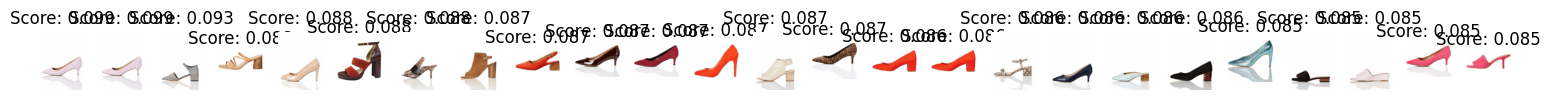

In [145]:
# Query Pinecone with text embedding
queryText = "heels"
queryEmbedding = embed.text(
    texts=[queryText],
    model='nomic-embed-text-v1.5',
    task_type='search_query'
)['embeddings'][0]

# Search Pinecone index
queryResults = index.query(
    vector=queryEmbedding,
    top_k=25,
    namespace="test-namespace",
    include_metadata=True
)
# Display results in a grid
print(f"Query: {queryText}")
numResults = len(queryResults['matches'])
fig, axes = plt.subplots(1, numResults, figsize=(15, 3))

for idx, match in enumerate(queryResults['matches']):    
    # Find and display the matching image
    matchingImage = randomShoeImages[randomShoeImages['image_id'] == match['metadata']['imageId']]
    if not matchingImage.empty:
        imagePath = matchingImage['fullImagePath'].iloc[0]
        img = plt.imread(imagePath)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Score: {match['score']:.3f}")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [171]:
def createDescription(row): 
    return f"Title: {row['title']}. \nColor: {row['color']}.\nStyle: {row['style']}. \nProductType: {row['productType']}. \nBullet Points: {";".join(row['bulletPoints'])}"



In [173]:

randomShoeImages.loc[:, 'imageCreatedDescription'] = randomShoeImages.loc[:, 'imageCreatedDescription'] = randomShoeImages.apply(createDescription, axis=1)
imageDescriptions = randomShoeImages['imageCreatedDescription'].tolist()

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

pc.create_index(
    name="test-index-images",
    dimension=768,  # adjust this to match your embedding dimension
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

index = pc.Index("test-index-images")

# Embed images using nomic vision
textEmbeddingResults = embed.text(
    texts=imageDescriptions,
    model='nomic-embed-text-v1.5',
)
embeddings = imageEmbeddingsResult['embeddings']
batchSize = 200

for i in range(0, len(embeddings), batchSize):
    batchEnd = min(i + batchSize, len(embeddings))
    batchVectors = [(f"id_{j}", embeddings[j], { "category": "text", "imageId": randomShoeImages.iloc[j]['image_id'] }) for j in range(i, batchEnd)]
    print(index.upsert(vectors=batchVectors, namespace="text-test-namespace"))

{'upserted_count': 200}
{'upserted_count': 200}
{'upserted_count': 200}
{'upserted_count': 200}
{'upserted_count': 200}


Query: not red sneakers, different colors only


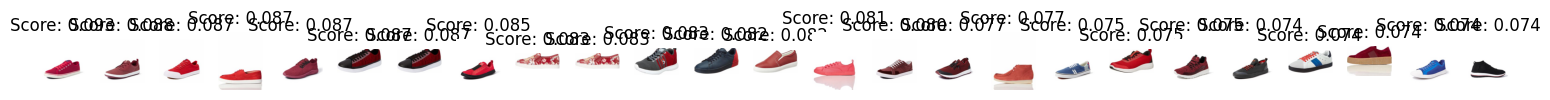

In [194]:
# Query Pinecone with text embedding
queryText = "not red sneakers, different colors only"
queryEmbedding = embed.text(
    texts=[queryText],
    model='nomic-embed-text-v1.5',
    task_type='search_query'
)['embeddings'][0]

# Search Pinecone index
queryResults = index.query(
    vector=queryEmbedding,
    top_k=25,
    namespace="text-test-namespace",
    include_metadata=True
)
# Display results in a grid
print(f"Query: {queryText}")
numResults = len(queryResults['matches'])
fig, axes = plt.subplots(1, numResults, figsize=(15, 3))

for idx, match in enumerate(queryResults['matches']):    
    # Find and display the matching image
    matchingImage = randomShoeImages[randomShoeImages['image_id'] == match['metadata']['imageId']]
    if not matchingImage.empty:
        imagePath = matchingImage['fullImagePath'].iloc[0]
        img = plt.imread(imagePath)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Score: {match['score']:.3f}")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


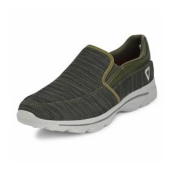

In [281]:
randomImage = randomShoeImages.sample(1)
imagePath = randomImage['fullImagePath'].iloc[0]
query = "Find me a similar shoe but in a different color"

# Display the random image
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(imagePath))
plt.axis('off')
plt.show()


Find me a similar shoe but in a different color
Query: White lace-up sneakers with a black heel accent.
Query: White lace-up sneakers with a black heel accent.


ValueError: Number of columns must be a positive integer, not 0

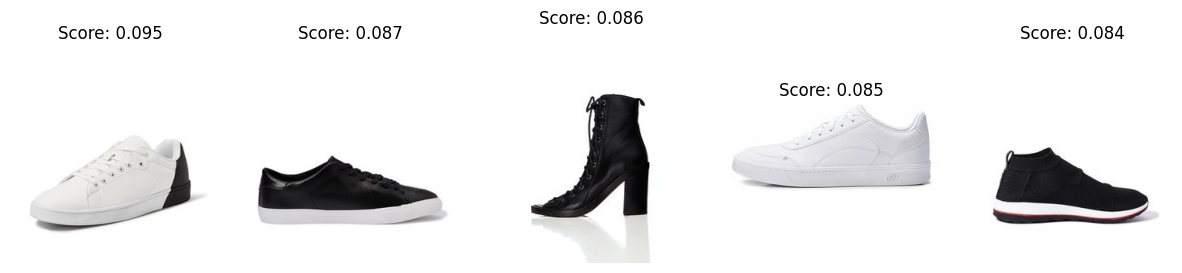

<Figure size 1500x300 with 0 Axes>

In [292]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
base64Image = encode_image(imagePath)

print(query)

response = client.responses.create(
    model="gpt-4o",
    input=[
        {
            "role": "developer",
            "content": [
                { "type": "input_text", "text": "I want you to create a description of a shoe given a users query and an image relating to the query. Make sure you extract the semantic meaning - negatives should be converted to positives. The query has no referance to the image so add all the image info into the query. State the description of what the user might be searching for. Provide no formatting, just a very short 10 word description of the target shoe." },],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text", 
                    "text": f"This is the users query: {query}. And this is the reference image:",
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64Image}",
                     "detail" : "low"
                },

            ]
        }
    ],
)

Query: White lace-up sneakers with a black heel accent.


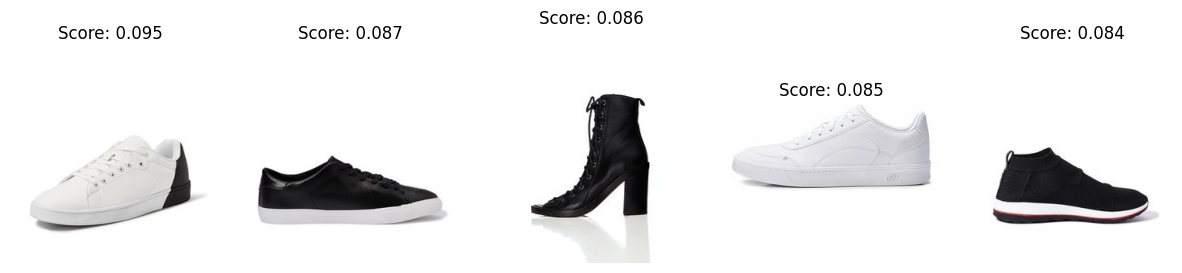

In [294]:
textQuery = response.output_text

queryEmbedding = embed.text(
    texts=[textQuery],
    model='nomic-embed-text-v1.5',
    task_type='search_query'
)['embeddings'][0]

index = pc.Index("test-index-images")
# Search Pinecone index
queryResults = index.query(
    vector=queryEmbedding,
    top_k=5,
    namespace="text-test-namespace",
    include_metadata=True
)
# Display results in a grid
print(f"Query: {textQuery}")
numResults = len(queryResults['matches'])
fig, axes = plt.subplots(1, numResults, figsize=(15, 3))

for idx, match in enumerate(queryResults['matches']):    
    # Find and display the matching image
    matchingImage = randomShoeImages[randomShoeImages['image_id'] == match['metadata']['imageId']]
    if not matchingImage.empty:
        imagePath = matchingImage['fullImagePath'].iloc[0]
        img = plt.imread(imagePath)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Score: {match['score']:.3f}")
        axes[idx].axis('off')

Query: White lace-up sneakers with a black heel accent.


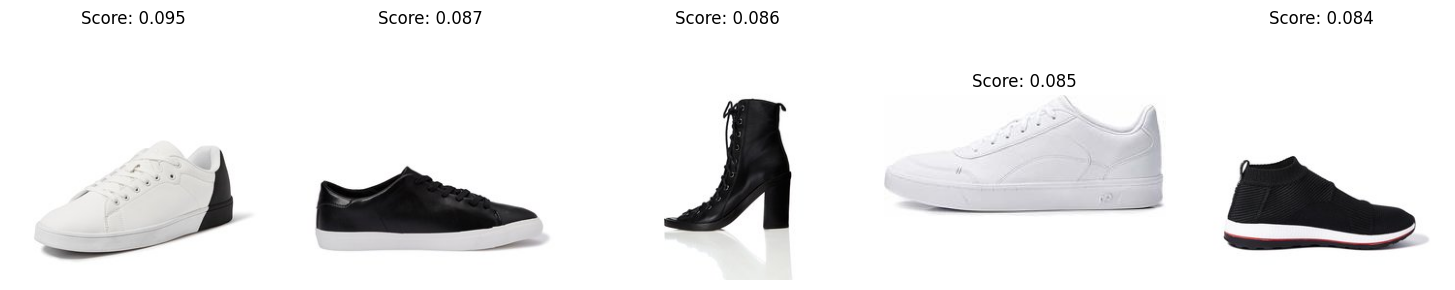

In [300]:
imageIndex = pc.Index("test-index")

# Search Pinecone index
queryResults = imageIndex.query(
    vector=queryEmbedding,
    top_k=5,
    namespace="test-namespace",
    include_metadata=True
)
# Display results in a grid
print(f"Query: {textQuery}")
numResults = len(queryResults['matches'])

fig, axes = plt.subplots(1, numResults, figsize=(15, 3))

for idx, match in enumerate(queryResults['matches']):    
    # Find and display the matching image
    matchingImage = randomShoeImages[randomShoeImages['image_id'] == match['metadata']['imageId']]
    if not matchingImage.empty:
        imagePath = matchingImage['fullImagePath'].iloc[0]
        img = plt.imread(imagePath)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Score: {match['score']:.3f}")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()